In [2]:
from PIL import Image             
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageChops
import numpy as np
import pandas as pd
import torchvision
from torch.utils.data import Dataset
import warnings
import copy
import torch.nn.functional as F
warnings.filterwarnings("ignore")

In [3]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(20)

In [4]:
import os
def make_txt_file(path):
    
    # Classes: train, eval, test
    train_data=open('train.txt', 'w')
    eval_data=open('eval.txt', 'w')

    
    typenames=os.listdir(path)
    
    for typename in typenames:
        imgpath=os.path.join(path,typename)
        imgnames=os.listdir(imgpath)
            
        i=0

        for imgname in imgnames:  
            if imgname.endswith('.jpg'):
                name = imgpath + '/' + imgname + '*' + str(typenames.index(typename)) + '\n'  
                if i%10==0:
                    eval_data.write(name)
                else:
                    train_data.write(name)  

                i+=1
                
    train_data.close()
    eval_data.close()


In [5]:
class MyDataSet(Dataset):
    def __init__(self, dataset_type, transform=None, update_dataset=False):
        """
        dataset_type: [train, eval, test]
        """
 
        dataset_path = '/kaggle/input/caltech256/256_ObjectCategories/'
        read_path='/kaggle/working/'
 
        if update_dataset:
            make_txt_file(dataset_path)  # update datalist
 
        self.transform = transform
        self.sample_list = list()
        self.dataset_type = dataset_type
        f = open(read_path + self.dataset_type + '.txt')
        lines = f.readlines()
        for line in lines:
            self.sample_list.append(line.strip())
        f.close()
 
    def __getitem__(self, index):
        item = self.sample_list[index]
        img = Image.open(item.split('*')[0])
        img=img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        label = int(item.split('*')[-1])
        return img, label
 
    def __len__(self):
        return len(self.sample_list)

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomCrop((224,224),padding=16),
        torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

train_data=MyDataSet('train',transform=data_transforms['train'],update_dataset=True)
eval_data=MyDataSet('eval',transform=data_transforms['eval'])


In [7]:
class ResidualBlock(nn.Module):
    def __init__(self,inchannel,outchannel,stride = 1,shortcut = None):

        super().__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel,outchannel,3,stride,1,bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(),
            nn.Conv2d(outchannel,outchannel,3,1,1,bias=False), 
            nn.BatchNorm2d(outchannel)
         )
        
        self.relu=nn.ReLU(inplace=True)
        self.right = shortcut

    def forward(self, input):
        out = self.left(input)
        residual = input if self.right is None else self.right(input)
        out+=residual
        return self.relu(out)

In [8]:
class ResNet(nn.Module):
        

    def __init__(self,num_class=1000):
        super().__init__()
    
        self.pre = nn.Sequential(
            nn.Conv2d(3,64,7,2,3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3,2,1)
        )

            
        self.layer1 = self._make_layer(64,64,2)
        self.layer2 = self._make_layer(64,128,2,stride=2) 
        self.layer3 = self._make_layer(128,256,2,stride=2)
        self.layer4 = self._make_layer(256,512,2,stride=2)
        self.averagepool=nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(512,num_class)

    def _make_layer(self,inchannel,outchannel,block_num,stride = 1):
        
        if stride != 1 or inchannel != outchannel:
            shortcut = nn.Sequential(
                nn.Conv2d(inchannel,outchannel,1,stride,bias=False),
                nn.BatchNorm2d(outchannel)
            )
        else:
            shortcut=None 

        layers = []
        layers.append(ResidualBlock(inchannel,outchannel,stride,shortcut))

            
        for i in range(1,block_num):
            layers.append(ResidualBlock(outchannel,outchannel))

        return nn.Sequential(*layers)


    def forward(self, input):
        x = self.pre(input)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.averagepool(x) 
                                
        x = x.view(x.size(0),-1)
        return self.fc(x)


In [9]:
res=ResNet(num_class=256).cuda().half()

print(res)

ResNet(
  (pre): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, mo

In [10]:
EPOCH = 40
BATCH_SIZE=128

optimizer=torch.optim.SGD(res.parameters(), lr=0.01, momentum=0.9)

loss_func=nn.CrossEntropyLoss().half()
torch.cuda.empty_cache()

train_loader=Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=2)
eval_loader=Data.DataLoader(dataset=eval_data,batch_size=200,
                             shuffle=True, num_workers=2)

In [11]:
train_losses=[]
eval_losses=[]
train_accs=[]
eval_accs=[]
best_model_wts = copy.deepcopy(res.state_dict())       
best_acc = 0.0


for epoch in range(EPOCH):
    print('Epoch: %4s'%epoch)
    
    
    accuracy=0
    data_size=0
    batch_loss=0
    res.train()  
    
    for step,(x,y) in enumerate(train_loader):
        b_x=Variable(x).cuda().half()
        b_y=Variable(y).cuda()
        
        output=res(b_x)   
        loss=loss_func(output,b_y)
        batch_loss+=loss.data
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
        pred_y=torch.max(output,1)[1].cuda().data.squeeze()
        accuracy+=sum(pred_y==b_y).to(torch.float16)
        data_size+=b_y.size(0)
        
        
        
    train_acc=accuracy/data_size
    train_loss=batch_loss/(step+b_y.size(0)/128)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    print('| train loss: ',train_loss,
          '| Train_acc: %6s '% train_acc.data)
    
    
    
    with torch.no_grad():
        res.eval()         

        accuracy=0
        data_size=0
        batch_loss=0
        for step,(x,y) in enumerate(eval_loader):
            b_x=Variable(x).cuda().half()
            b_y=Variable(y).cuda()       
            output=res(b_x)         
            pred_y=torch.max(output,1)[1].cuda().data.squeeze()
            accuracy+=sum(pred_y==b_y).to(torch.float16)
            data_size+=b_y.size(0)
            batch_loss+=loss_func(output,b_y).data
            
            torch.cuda.empty_cache()
            
        eval_acc=accuracy/data_size
        eval_loss=batch_loss/(step+b_y.size(0)/128)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)
        
        
        if eval_acc>best_acc:
            best_acc = eval_acc
            best_model_wts = copy.deepcopy(res.state_dict())    
            
    #exp_lr_scheduler.step()     
    
    
    print('| eval loss: ',eval_loss,
          '| Eval_acc: %6s \n'%eval_acc.data) 
    
print('Best Eval acc: %6s'%best_acc)

Epoch:    0
| train loss:  tensor(5.1797, device='cuda:0', dtype=torch.float16) | Train_acc: tensor(0.0663, device='cuda:0', dtype=torch.float16) 
| eval loss:  tensor(5.2773, device='cuda:0', dtype=torch.float16) | Eval_acc: tensor(0.0598, device='cuda:0', dtype=torch.float16) 

Epoch:    1
| train loss:  tensor(4.5430, device='cuda:0', dtype=torch.float16) | Train_acc: tensor(0.1268, device='cuda:0', dtype=torch.float16) 
| eval loss:  tensor(4.6484, device='cuda:0', dtype=torch.float16) | Eval_acc: tensor(0.1010, device='cuda:0', dtype=torch.float16) 

Epoch:    2
| train loss:  tensor(4.0859, device='cuda:0', dtype=torch.float16) | Train_acc: tensor(0.1821, device='cuda:0', dtype=torch.float16) 
| eval loss:  tensor(3.9082, device='cuda:0', dtype=torch.float16) | Eval_acc: tensor(0.2003, device='cuda:0', dtype=torch.float16) 

Epoch:    3
| train loss:  tensor(3.6816, device='cuda:0', dtype=torch.float16) | Train_acc: tensor(0.2330, device='cuda:0', dtype=torch.float16) 
| eval los

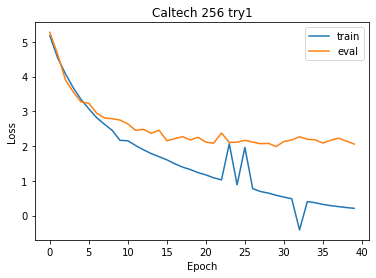

In [12]:
x=np.arange(len(train_losses))
plt.plot(x,train_losses,label='train')
plt.plot(x,eval_losses,label='eval')
plt.title('Caltech 256 try1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

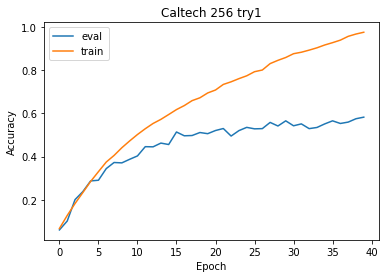

In [13]:
plt.plot(x,eval_accs,label='eval')
plt.plot(x,train_accs,label='train')
plt.title('Caltech 256 try1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
torch.save(best_model_wts,'Caltech 256 try1 best.pkl')
torch.save(res.state_dict(),'Caltech 256 try1 100E.pkl')